# Importing Libraries

In [90]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import zscore
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM

# Analyzing the Amazon (AMZN) Stock

In [95]:
stock = yf.Ticker('AMZN')

In [96]:
data = stock.history(period='max',end='2020-12-09')

Text(0.5, 1.0, 'AMZN Close Price Variation')

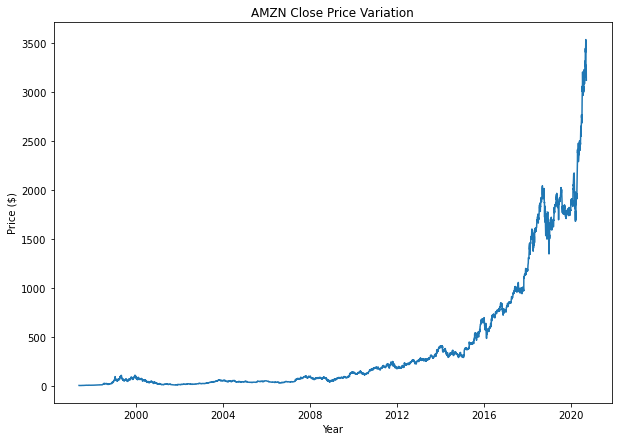

In [97]:
plt.figure(figsize=(10,7))
plt.plot(data['Close'])
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.title('AMZN Close Price Variation')

In [98]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15,2.44,2.50,1.93,1.96,72156000,0,0.0
1997-05-16,1.97,1.98,1.71,1.73,14700000,0,0.0
1997-05-19,1.76,1.77,1.62,1.71,6106800,0,0.0
1997-05-20,1.73,1.75,1.64,1.64,5467200,0,0.0
1997-05-21,1.64,1.65,1.38,1.43,18853200,0,0.0


In [99]:
data.shape

(5871, 7)

In [100]:
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5871.000000,5871.000000,5871.000000,5871.000000,5.871000e+03,5871.0,5871.000000
mean,387.008648,391.418152,382.187057,387.024945,7.503983e+06,0.0,0.001192
std,618.452909,625.194738,610.871202,618.379252,7.268525e+06,0.0,0.053802
min,1.410000,1.450000,1.310000,1.400000,4.872000e+05,0.0,0.000000
25%,38.040000,38.680000,37.330000,38.000000,3.681950e+06,0.0,0.000000
50%,84.100000,85.460000,82.470000,84.040000,5.644500e+06,0.0,0.000000
75%,368.225000,372.820000,365.110000,368.870000,8.508550e+06,0.0,0.000000
max,3547.000000,3552.250000,3486.690000,3531.450000,1.043292e+08,0.0,3.000000


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5871 entries, 1997-05-15 to 2020-09-11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5871 non-null   float64
 1   High          5871 non-null   float64
 2   Low           5871 non-null   float64
 3   Close         5871 non-null   float64
 4   Volume        5871 non-null   int64  
 5   Dividends     5871 non-null   int64  
 6   Stock Splits  5871 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 366.9 KB


In [102]:
data.drop(columns=['Dividends','Stock Splits'],inplace=True)

In [103]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
1997-05-15,2.44,2.50,1.93,1.96,72156000
1997-05-16,1.97,1.98,1.71,1.73,14700000
1997-05-19,1.76,1.77,1.62,1.71,6106800
1997-05-20,1.73,1.75,1.64,1.64,5467200
1997-05-21,1.64,1.65,1.38,1.43,18853200


In [104]:
stock.major_holders

,0,1
0,15.12%,% of Shares Held by All Insider
1,57.69%,% of Shares Held by Institutions
2,67.97%,% of Float Held by Institutions
3,4038,Number of Institutions Holding Shares


In [105]:
data.corr() #High correlation between all ohlc price values

,Open,High,Low,Close,Volume
Open,1.000000,0.999912,0.999887,0.999807,-0.230185
High,0.999912,1.000000,0.999847,0.999903,-0.228519
Low,0.999887,0.999847,1.000000,0.999906,-0.231882
Close,0.999807,0.999903,0.999906,1.000000,-0.230119
Volume,-0.230185,-0.228519,-0.231882,-0.230119,1.000000


# Data Preparation

In [106]:
norm_data = zscore(data) #Normalizing the dataset

In [107]:
norm_data = pd.DataFrame(norm_data,columns=data.columns)

In [108]:
norm_data

,Open,High,Low,Close,Volume
0,-0.621877,-0.622128,-0.622536,-0.622753,8.895550
1,-0.622637,-0.622960,-0.622896,-0.623125,0.990109
2,-0.622976,-0.623296,-0.623044,-0.623158,-0.192240
3,-0.623025,-0.623328,-0.623011,-0.623271,-0.280243
4,-0.623170,-0.623488,-0.623437,-0.623610,1.561553
...,...,...,...,...,...
5866,4.739635,4.783048,4.467677,4.702361,0.175816
5867,4.458264,4.574055,4.498570,4.468213,-0.193974
5868,4.553655,4.657765,4.588613,4.660296,-0.318563
5869,4.722203,4.732484,4.564956,4.509082,-0.299025


In [110]:
# An output of 1 means the open price of day i is greater than the close price on day i-1, and for all other cases, output is 0
output_column = []
for i in range(1,len(data)) :
    if data.iloc[i]['Open'] > data.iloc[i-1]['Close'] :
        output_column.append(1)
    else :
        output_column.append(0)

In [111]:
norm_data.drop(index=0,axis=0,inplace=True)

In [112]:
norm_data['outcome'] = output_column

In [113]:
norm_data['outcome'].value_counts(normalize=True)  #Almost equal distribution of both classes in dataset

1    0.525213
0    0.474787
Name: outcome, dtype: float64

# Classification 

In [114]:
x = norm_data.drop(columns='outcome',axis=1)
y = norm_data['outcome']

In [115]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=11)

In [123]:
classifier_list = []
train_accuracy = []
test_accuracy = []

In [124]:
#Logistic Regression
classifier = LogisticRegression()
classifier.fit(xtrain,ytrain)
ypredict = classifier.predict(xtest)
classifier_list.append('Logistic Regression')
train_accuracy.append(np.round(100*classifier.score(xtrain,ytrain),2))
test_accuracy.append(np.round(100*accuracy_score(ytest,ypredict),2))

In [125]:
#Decision Tree
classifier = DecisionTreeClassifier()
classifier.fit(xtrain,ytrain)
ypredict = classifier.predict(xtest)
classifier_list.append('Decision Tree')
train_accuracy.append(np.round(100*classifier.score(xtrain,ytrain),2))
test_accuracy.append(np.round(100*accuracy_score(ytest,ypredict),2))

In [126]:
#Random Forest
classifier = RandomForestClassifier()
classifier.fit(xtrain,ytrain)
ypredict = classifier.predict(xtest)
classifier_list.append('Random Forest')
train_accuracy.append(np.round(100*classifier.score(xtrain,ytrain),2))
test_accuracy.append(np.round(100*accuracy_score(ytest,ypredict),2))

In [128]:
#Preparing data for LSTM
xtrain =np.array(xtrain)
xtest =np.array(xtest)

new_xtrain = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1])
new_xtest = xtest.reshape(xtest.shape[0], 1, xtest.shape[1])

In [129]:
#LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, xtrain.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(new_xtrain, ytrain, epochs=200, batch_size=10, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
411/411 [==============================] - 0s 922us/step - loss: 1.7019
Epoch 2/200
411/411 [==============================] - 0s 832us/step - loss: 0.7173
Epoch 3/200
411/411 [==============================] - 0s 844us/step - loss: 0.7016
Epoch 4/200
411/411 [==============================] - 0s 857us/step - loss: 0.6964
Epoch 5/200
411/411 [==============================] - 0s 843us/step - loss: 0.6943
Epoch 6/200
411/411 [==============================] - 0s 852us/step - loss: 0.6931
Epoch 7/200
411/411 [==============================] - 0s 852us/step - loss: 0.6922
Epoch 8/200
411/411 [==============================] - 0s 837us/step - loss: 0.6915
Epoch 9/200
411/411 [==============================] - 0s 920us/step - loss: 0.6909
Epoch 10/200
411/411 [==============================] - 0s 889us/step - loss: 0.6905
Epoch 11/200
411/411 [==============================] - 0s 932us/step - loss: 0.6902
Epoch 12/200
411/411 [==============================] - 0s 825us/step - lo

In [130]:
classifier_list.append('LSTM')
ypredict_train = model_lstm.predict(new_xtrain)
ite = []
for i in range(len(ypredict_train)) :
    if ypredict_train[i][0] > 0.5 :
        ite.append(1)
    else :
        ite.append(0)
ypredict_train = ite
train_accuracy.append(np.round(100*accuracy_score(ypredict_train,ytrain),2))

ypredict_test = model_lstm.predict(new_xtest)
ite = []
for i in range(len(ypredict_test)) :
    if ypredict_test[i][0] > 0.5 :
        ite.append(1)
    else :
        ite.append(0)
ypredict_test = ite
test_accuracy.append(np.round(100*accuracy_score(ypredict_test,ytest),2))

In [131]:
# According to testing accuracies, all the models tested are only slightly better at classification than randomly tossing a coin and selecting a class based on that outcome. Both decision tree and random forest have completely overfit the training data.
final_results = pd.DataFrame()
final_results['Classifier'] = classifier_list
final_results['Training Accuracy (%)'] = train_accuracy
final_results['Testing Accuracy (%)'] = test_accuracy
final_results

,Classifier,Training Accuracy (%),Testing Accuracy (%)
0,Logistic Regression,54.15,55.65
1,Decision Tree,100.00,50.26
2,Random Forest,100.00,51.22
3,LSTM,54.47,54.86
